In [118]:
import copy
import sys
sys.path.insert(0, "../../")
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Animator, Atom_Collection_Plotter
from classes.calculators.lennardjones import LJGauss
import matplotlib.pyplot as plt
from classes.kmeans import KMeans
import numpy as np

In [119]:
def custom_metric(u, v):
    print(v-u)
    return v-u

class PairDistances():
    def __init__(self, color='C1'):
        self.xwidth = 0.5
        self.color = color
        self.bin_edges = np.arange(0,7.01,self.xwidth)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) /2
    
    def descriptor(self,atom_cols):
        result = np.zeros(shape=(len(atom_cols), 12, 14))
        for i, atom_col in enumerate(atom_cols):
            atom_positions = atom_col.positions
            diffs = atom_positions[np.newaxis, :, :] - atom_positions[:, np.newaxis, :]
            dists = np.linalg.norm(diffs, axis=-1)
            for j, dist in enumerate(dists):
                bars, _ = np.histogram(dist,self.bin_edges)
                result[i][j] = bars
        return result

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([0,20.1])
        ax.set_title(self.__class__.__name__)

class Atom_Plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
    
    def __call__(self, atom_col, ax=None, plot_cell=False):
        return super().__call__(atom_col, ax, plot_cell)

    def plot_atom_col(self, atom_col):
        ax = atom_col.plot_axes
        plot_elems = []
        if atom_col.plot_elems["atoms"] is None:
            for position, frozen, label in zip(atom_col.positions, atom_col.frozens, atom_col.label):
                p = ax.plot(position[0], position[1], "o", c=f"C{label}", ms=self.markersize, alpha=self.alpha, markeredgecolor="k")[0]
                plot_elems.append(p)
        else:
            for position, plot_elem in zip(atom_col.positions, atom_col.plot_elems["atoms"]):
                plot_elem.set_data(position[0], position[1])
            plot_elems = atom_col.plot_elems["atoms"]
        return plot_elems



In [141]:
pair_distances = PairDistances()
atom_writer = Atom_File_handler()
relaxed_cols = []
for i in range(3):
    relaxed_cols += atom_writer.load_atom_collections(filename=f"../exercise 38/relaxed_structs{i}")

pair_dists = pair_distances.descriptor(atom_cols=relaxed_cols)
reshaped_pair_dists = pair_dists.reshape(12*len(relaxed_cols), 14)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data=reshaped_pair_dists, init_mus=np.array([reshaped_pair_dists[np.random.randint(0, len(reshaped_pair_dists), 1)] for _ in range(n_clusters)]).squeeze(1))

In [142]:
for atom_col,pair_dist in zip(relaxed_cols, pair_dists):
    labels = kmeans.predict(pair_dist)
    atom_col.label=labels

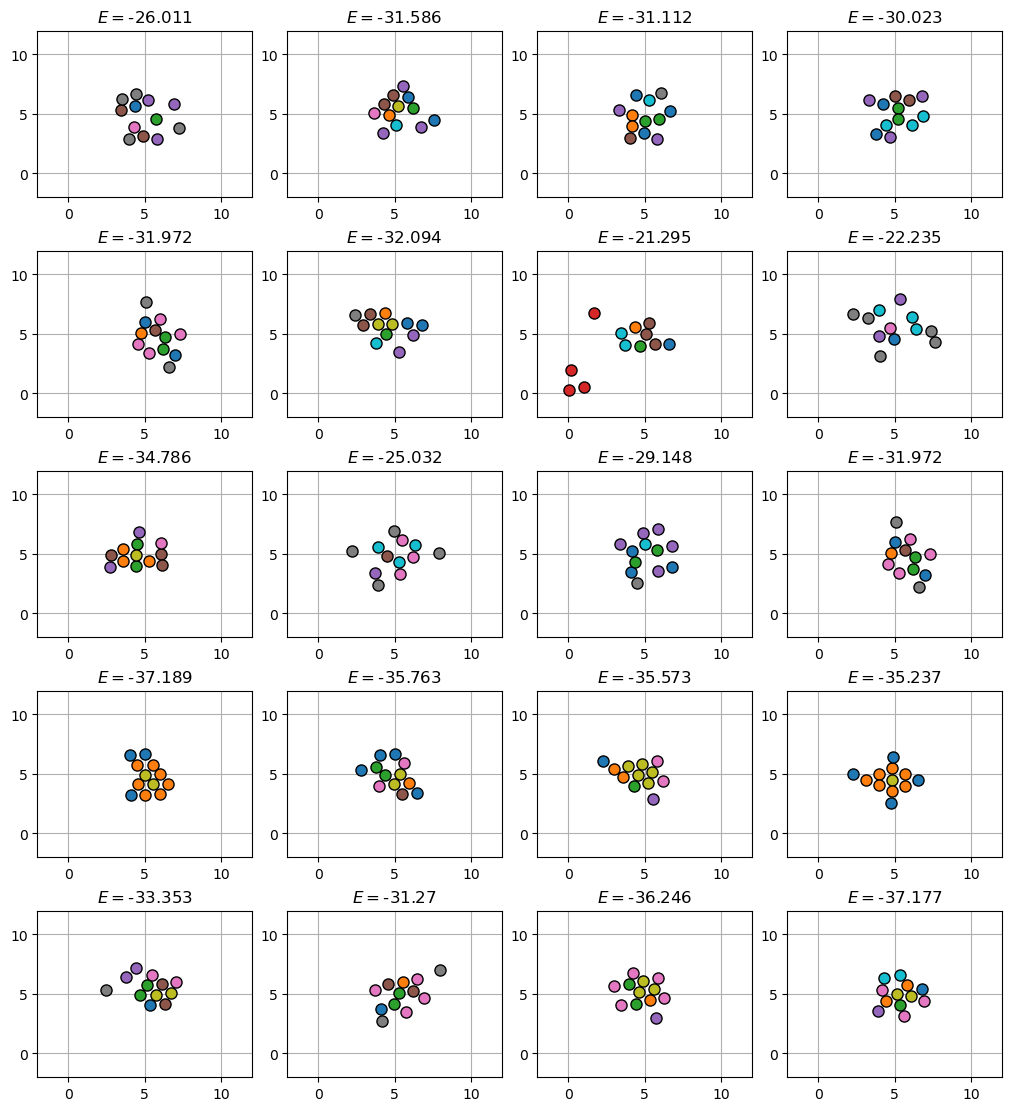

In [143]:
fig, axs = plt.subplots(5,4, figsize=(10,11), layout="constrained")
atom_plotter = Atom_Plotter(markersize=8)

indices = []
plotted_cols = []
plot_num = 0
while plot_num < 20:
    index = np.random.randint(0, len(relaxed_cols), 1)[0]
    if index not in indices:
        rel_col = relaxed_cols[index]
        plotted_cols.append(rel_col)
        ax = axs.flatten()[plot_num]
        ax.grid()
        #ax.set_aspect("equal")
        ax.set_xlim([-2.0, 12.0])
        ax.set_ylim([-2.0, 12.0])
        atom_plotter(atom_col=rel_col, ax=ax)
        ax.set_title(r"$E=$"+f"{round(rel_col.get_potential_energy(),3)}")
        rel_col.reset_plot_axes()
        plot_num+=1

In [144]:
from classes.regression.regressers import ridge_regressor, pol_kernel_regressor
n_clusters = 10
y_data = np.zeros(shape=(len(relaxed_cols),1))
X_data = np.zeros(shape=(len(relaxed_cols), n_clusters))

for i, atom_col in enumerate(relaxed_cols):
    y_data[i] = atom_col.get_potential_energy()
    X_data[i] = np.array([len(np.argwhere(atom_col.label == i)) for i in range(n_clusters)])

In [145]:
regressor = ridge_regressor(x_data=X_data, y_data=y_data.T[0], N_deg=1, lamb=1e-5)
pol_regressor = pol_kernel_regressor(x_data=X_data, y_data=y_data.T[0], N_deg=1, lamb=1e-5)

In [146]:
class local_LJGenergy(LJGauss):
    def __init__(self, gauss_sigma2=0.02, gauss_eps=1, r0=1.7):
        super().__init__(gauss_sigma2, gauss_eps, r0)
    
    def __call__(self, atom_col):
        atom_positions =  atom_col.positions
        diff = atom_positions[np.newaxis, :, :] - atom_positions[:, np.newaxis, :]
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        return 0.5*np.sum(super().__call__(r), axis=0)

In [147]:
s = local_LJGenergy()
np.sum(s(relaxed_cols[0]))

-26.90009858302494

In [148]:
relaxed_cols[0].get_potential_energy()
np.eye(X_data.shape[1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [149]:
betas = np.linalg.inv(X_data.T @ X_data + 1e-5*np.eye(X_data.shape[1]))@ X_data.T @ y_data
print(betas)
real_local_energies = []
fitted_local_energies = []
cols = []
local_energy_calculator = local_LJGenergy()
for atom_col in relaxed_cols:
    real_local_energies.append(local_energy_calculator(atom_col=atom_col))
    atom_col_betas = []
    atom_col_colors = []
    for label in labels:
        atom_col_betas.append(betas[label,0])
        atom_col_colors.append(f"C{label}")
    cols.append(atom_col_colors)
    fitted_local_energies.append(atom_col_betas)

[[-2.28759267]
 [-3.24648934]
 [-3.29304055]
 [-0.25552573]
 [-2.18417158]
 [-2.49613051]
 [-3.17817661]
 [-1.22301108]
 [-3.53709548]
 [-2.64924631]]


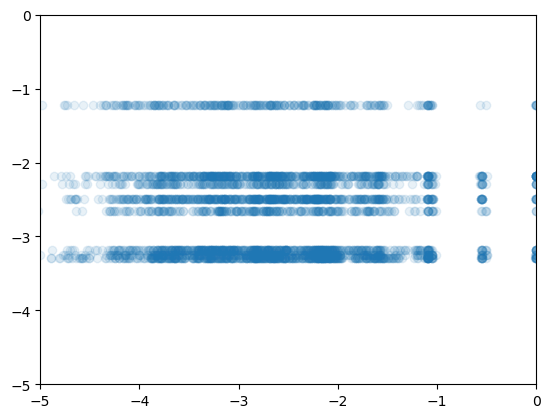

In [150]:
fig, ax = plt.subplots()
ax.set_xlim([-5,0])
ax.set_ylim([-5,0])
for real_local, fitted_local, col in zip(real_local_energies, fitted_local_energies, cols):
    ax.plot(real_local, fitted_local, 'o', c="C0", alpha=0.1)

In [ ]:
fitted_local_energies

[-3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2.4978924606570603,
 -2.744792584726442,
 -3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2.4978924606570603,
 -2.744792584726442,
 -3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2.4978924606570603,
 -2.744792584726442,
 -3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2